In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
!pip install unidecode

from unidecode import unidecode

pd.set_option("display.max_columns", 40)
pd.options.display.width=None
pd.options.display.float_format = '{:,.2f}'.format

# Explicación de las columnas

- **id:** Id de base de datos del registro
- **name:** Nombre de la publicación
- **operation_type:** Tipo de operación que se esta realizando con la propiedad
- **operation_currency:** Moneda de la operación
- **operation_amount:** Monto de la operación
- **expenses_currency:** Moneda de las expensas
- **expenses_amount:** Monto de las expensas
- **total_mts:** Total de metros de la propiedad
- **covered_mts:** Total de metros cubiertos de la propiedad
- **rooms:** Cantidad de ambientes
- **bedrooms:** Cantidad de dormitorios
- **bathrooms:** Cantidad de baños
- **garages:** Cantidad de garages
- **antique:** Antiguedad de la propiedad
- **building_layout:** Disposición del edificio
- **orientation:** Orientación de la propiedad
- **number_of_floors:** Cantidad de pisos del edificio
- **apartments_per_floor:** Departamentos por cada piso
- **real_estate_type:** Tipo de propiedad
- **posting_type:** Tipo de publicación
- **publisher_id:** Id de base de datos del publicador
- **publisher_name:** Nombre del publicador
- **address:** Dirección de la propiedad
- **city_id:** Id de base de datos del barrio/localidad de la propiedad
- **city:** Nombre del barrio de la propiedad
- **state_id:** Id de base de datos de la provincia de la propiedad
- **state:** Nombre de la provincia de la propiedad
- **country_id:** Id de base de datos del país de la propiedad
- **country:** Nombre del país de la propiedad
- **latitude:** Ubicación en latitud de la propiedad
- **longitude:** Ubicación en longitud de la propiedad
- **reserved:** Tiene reserva?
- **publication_antiquity:** Antiguedad de la publicación
- **url:** Dirección web de la publicación

- TODO: Agregar mas informacion sobre a que corresponde segun el codigo civil el real_estate_type
- TODO: Analizar por que terrenos tienen metros cubiertos
- TODO: En la eliminacion de datos por outlier (percentil 0.999), una idea mas copada seria calcular el percentil de cada variable agrupando antes por cantidad de ambientes por ejemplo.
- TODO: Ver si no conviene a la hora de eliminar registros profundizar el análisis por tipo de propiedad y barrio
- TODO: Calcular la media de las propiedades segun tipo de propiedad, cantidad de ambientes y barrio
- TODO: Ver que hacer con building_layout y orientation ya que hay pocos datos pero pueden ser variables interesantes
- TODO: En la parte de unificación de moneda, podemos armar un script para traer los distintos tipos de cambio y usar un promedio (Lo tengo hecho en otro lado). Ver opción de armar campo Fcha de publicción pra convertir expensa a valor dolar de ese momento
- TODO: Analizar la relación de expensa vs precio de venta
- TARGET: predecir precio de venta en usd
- TODO: ver vble antique, si la tomamos como categorica. Como tratar "en construccion" y "a estrenar". Cuanto impacta en el precio
- TODO: ELimnar aquellos registros que tienen 0 en valor de venta, ya que es nuestro target

# Lectura del Dataset

In [ ]:
df = pd.read_excel("/content/Listings.xlsx")
df.sample(5)

,id,name,operation_type,operation_currency,operation_amount,expenses_currency,expenses_amount,total_mts,covered_mts,rooms,bedrooms,bathrooms,garages,antique,building_layout,orientation,number_of_floors,apartments_per_floor,real_estate_type,posting_type,publisher_id,publisher_name,address,city_id,city,state_id,state,country_id,country,latitude,longitude,reserved,publication_antiquity,url
12168,53379258,"Terreno Lote en Venta Ubicado en Belgrano, Cap...",Venta,USD,"810,000.00",NaN,NaN,187.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Terrenos,PROPERTY,17027878,Gustavo Abascal Propiedades,Virrey Loreto 2800,V1-C-1003652,Belgrano,V1-B-6,Capital Federal,V1-A-1,Argentina,-34.57,-58.45,False,Publicado hace 42 días,https://www.zonaprop.com.ar/propiedades/clasif...
3240,51671256,Depto 2 Ambientes Cochera y Amenities en Quart...,Venta,USD,"225,000.00",ARS,"153,000.00",50.00,46.00,2.00,1.00,1.00,1.00,10,Contrafrente,SE,NaN,NaN,Apartamento,PROPERTY,17116526,Evoluer Real Estate Co.,Ortega y Gasset 1929,V1-C-1003694,Palermo,V1-B-6,Capital Federal,V1-A-1,Argentina,-34.57,-58.43,False,Publicado hace 364 días,https://www.zonaprop.com.ar/propiedades/clasif...
10309,53234166,Departamento Monoambiente en Venta - 32 m&sup2...,Venta,USD,"99,000.00",ARS,"20,000.00",32.00,32.00,1.00,NaN,1.00,NaN,35,Frente,NO,NaN,NaN,Apartamento,PROPERTY,17161084,ESTUDIO YACOUB,Carlos Pellegrini y Macelo T. de Alvear,V1-C-1003656,Retiro,V1-B-6,Capital Federal,V1-A-1,Argentina,-34.60,-58.38,False,Publicado hace 68 días,https://www.zonaprop.com.ar/propiedades/clasif...
3534,51838571,Departamento - Belgrano,Venta,USD,"95,000.00",ARS,0.00,30.00,26.00,1.00,NaN,1.00,NaN,En construcción,Frente,NaN,NaN,NaN,Apartamento,PROPERTY,17010629,INTERWIN Marketing Inmobiliario,Olazabal y Cuba- Unidad 702,V1-C-1003652,Belgrano,V1-B-6,Capital Federal,V1-A-1,Argentina,-34.56,-58.46,False,Publicado hace 336 días,https://www.zonaprop.com.ar/propiedades/clasif...
14862,53532764,Donna Alberdi Esq Achaval,En Pozo,USD,"257,400.00",NaN,NaN,86.00,70.00,3.00,2.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,Vertical,DEVELOPMENT,17044062,JUSTEVILA,AV JUAN BAUTISTA ALBERDI 1536,V1-C-1003693,Caballito,V1-B-6,Capital Federal,V1-A-1,Argentina,-34.63,-58.45,False,NaN,https://www.zonaprop.com.ar/propiedades/empren...


In [ ]:
 !pip install ydata_profiling
 from ydata_profiling import ProfileReport
 # Usando pandas
 profilingreport = ProfileReport(df, title='dptos', minimal=True)
 profilingreport

Output hidden; open in https://colab.research.google.com to view.

# Limpieza de Datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16945 entries, 0 to 16944
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     16945 non-null  int64  
 1   name                   16945 non-null  object 
 2   operation_type         16945 non-null  object 
 3   operation_currency     16912 non-null  object 
 4   operation_amount       16912 non-null  float64
 5   expenses_currency      14182 non-null  object 
 6   expenses_amount        14182 non-null  float64
 7   total_mts              16878 non-null  float64
 8   covered_mts            15883 non-null  float64
 9   rooms                  15304 non-null  float64
 10  bedrooms               13421 non-null  float64
 11  bathrooms              15470 non-null  float64
 12  garages                5066 non-null   float64
 13  antique                15461 non-null  object 
 14  building_layout        10121 non-null  object 
 15  or

## Eliminación de columnas

### Eliminación por imposibilidad de estimar

Existen algunas columnas que tienen muy pocos datos y decidimos eliminarlas ya que no hay forma objetiva de imputarles un valor. Entre ellas tenemos:
- number_of_floors
- apartments_per_floor

In [ ]:
df.drop(columns=['number_of_floors','apartments_per_floor'], inplace=True)

In [ ]:
df.head(1)

,id,name,operation_type,operation_currency,operation_amount,expenses_currency,expenses_amount,total_mts,covered_mts,rooms,bedrooms,bathrooms,garages,antique,building_layout,orientation,real_estate_type,posting_type,publisher_id,publisher_name,address,city_id,city,state_id,state,country_id,country,latitude,longitude,reserved,publication_antiquity,url
0,20374238,Excelente 3 Ambientes - Vista Plena a Plaza - ...,Venta,USD,"158,000.00",ARS,"40,000.00",55.00,55.00,3.00,2.00,1.00,NaN,50,Frente,NE,Apartamento,PROPERTY,17049913,Sanchez Naon,Mendoza 2628,V1-C-1003652,Belgrano,V1-B-6,Capital Federal,V1-A-1,Argentina,-34.56,-58.46,False,Publicado hace más de 1 año,https://www.zonaprop.com.ar/propiedades/clasif...


### Eliminacion por no aportar al análisis

In [ ]:
df.drop(columns=['url','publisher_id','city_id','state_id','country_id','publisher_name','name','address'], inplace=True)

## Eliminación de valores no analizables

Para este análisis nos centraremos únicamente en las propiedades en venta del tipo "Apartamento", "PH" o "Casa".

In [ ]:
df = df[df['real_estate_type'].isin(['Apartamento','PH','Casa'])]

## Eliminacion de valores de operation_amount en 0

In [ ]:
df = df[df['operation_amount'] != 0]

## Estimación de valores

### Reemplazar por cero u otro valor

Existen valores que podemos reemplazar por 0 ya que la ausencia de los mismos podemos interpretar que refiere a la no existencia de los mismos.
Es una variable que el vendedor publica, por lo que asumimos que los valores faltantes son de publicaciones "sin cochera" que no completan ese dato


In [ ]:
df['garages'] = df['garages'].fillna(0)

En el caso de bathrooms, completaremos los valores faltantes con 1 (Asumiendo un mínimo de baño)

In [ ]:
df[df['bathrooms'].isna()].real_estate_type.value_counts()

real_estate_type
Apartamento    257
PH              39
Casa            38
Name: count, dtype: int64

In [ ]:
df['bathrooms'] = df['bathrooms'].fillna(1)

En el caso de bedrooms:
- Completaremos con 0 aquellos listings donde el room sea igual a 1 (Monoambientes).
- Para aquellos casos que tengan rooms y bathrooms completos, realizaremos la resta entre dichas variables para tener algo mas aproximado
- Para el resto de casos lo dejaremos en 0

In [ ]:
df[df['bedrooms'].isna()].real_estate_type.value_counts()

real_estate_type
Apartamento    1523
PH               30
Casa             27
Name: count, dtype: int64

In [ ]:
df['bedrooms'] = np.where(df['rooms'] == 1, 0, df['bedrooms'])
# df['bedrooms'] = np.where((df['bedrooms'].isna()) & (~df['rooms'].isna()) & (~df['bathrooms'].isna()), df['rooms'] - df['bathrooms'], 0)

In [ ]:
df[df['bedrooms'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1808 entries, 23 to 16923
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1808 non-null   int64  
 1   operation_type         1808 non-null   object 
 2   operation_currency     1808 non-null   object 
 3   operation_amount       1808 non-null   float64
 4   expenses_currency      1606 non-null   object 
 5   expenses_amount        1606 non-null   float64
 6   total_mts              1807 non-null   float64
 7   covered_mts            1759 non-null   float64
 8   rooms                  1808 non-null   float64
 9   bedrooms               1808 non-null   float64
 10  bathrooms              1808 non-null   float64
 11  garages                1808 non-null   float64
 12  antique                1779 non-null   object 
 13  building_layout        1398 non-null   object 
 14  orientation            871 non-null    object 
 15  real_es

In [ ]:
df[df['bedrooms'].isna()].real_estate_type.value_counts()

real_estate_type
Apartamento    124
Casa            26
PH              25
Name: count, dtype: int64

Para los registros que tengan un valor mayor de metros cubiertos comparado con metros totales, le seteamos como máximo el de metros totales

# INVERTIR VARIABLES EN ESTOS CASOS. ASUMIR QUE SE EQUIVOCO EN DONDE COMPLETAR EL VALOR

In [ ]:
df[df['covered_mts'] > df['total_mts']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 1432 to 16321
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     27 non-null     int64  
 1   operation_type         27 non-null     object 
 2   operation_currency     27 non-null     object 
 3   operation_amount       27 non-null     float64
 4   expenses_currency      23 non-null     object 
 5   expenses_amount        23 non-null     float64
 6   total_mts              27 non-null     float64
 7   covered_mts            27 non-null     float64
 8   rooms                  24 non-null     float64
 9   bedrooms               26 non-null     float64
 10  bathrooms              27 non-null     float64
 11  garages                27 non-null     float64
 12  antique                27 non-null     object 
 13  building_layout        2 non-null      object 
 14  orientation            16 non-null     object 
 15  real_es

In [ ]:
condition = df['covered_mts'] > df['total_mts']
df.loc[condition, 'covered_mts'] = df.loc[condition, 'total_mts']

Para los registros que no tengan metros cubiertos, lo completamos con la cantidad de metros totales para tener un valor aproximado

In [ ]:
condition = df['covered_mts'].isna()
df.loc[condition, 'covered_mts'] = df.loc[condition, 'total_mts']

## Unificación de moneda

Existen registros que estan en moneda ARS ($). Estos los transformaremos a USD utilizando el TC seleccionado para asi unificar los análisis

#Chequear la importancia de las expensas a la hora de predecir el valor de operation_amount

In [ ]:
dolar_bna = 909.5
dolar_blue = 1220
currency_rate = (dolar_bna + dolar_blue) / 2
df['operation_amount'] = np.where(df['operation_currency'] == '$', df['operation_amount'] / currency_rate, df['operation_amount'])
df['operation_currency'] = 'USD'
df['expenses_amount'] = np.where(df['expenses_currency'] == 'ARS', df['expenses_amount'] / currency_rate, df['expenses_amount'])
df['expenses_currency'] = 'USD'

In [ ]:

df.drop(columns=['operation_currency','expenses_currency'], inplace=True)
#columna infomrativa, ya se que todos los valroes estan en usd

## Transformación de columnas string

La columna antique no solo contiene registros con antiguedad en años, sino que tambien contamos con valores como por ejemplo "A estrenar" o "En construcción". Estos los reemplazaremos por 0 y transformaremos la columna en flotante (Podria ser por entero pero como tiene NaN, pandas no lo soporta)

In [ ]:
df.antique.value_counts()

antique
A estrenar         3678
En construcción    1635
40                  947
50                  910
45                  456
                   ... 
1930                  1
134                   1
138                   1
1992                  1
129                   1
Name: count, Length: 124, dtype: int64

In [ ]:
#condition = df['antique'].isin({'A estrenar','En construcción'})
#df.loc[condition, 'antique'] = 0
#df['antique'] = df['antique'].astype('float')

df.loc[df['antique'] == 'A estrenar', 'antique'] = 0
df.loc[df['antique'] == 'En construcción', 'antique'] = -1
df['antique'] = df['antique'].astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13649 entries, 0 to 16942
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     13649 non-null  int64  
 1   operation_type         13649 non-null  object 
 2   operation_amount       13649 non-null  float64
 3   expenses_amount        12296 non-null  float64
 4   total_mts              13641 non-null  float64
 5   covered_mts            13646 non-null  float64
 6   rooms                  13537 non-null  float64
 7   bedrooms               13474 non-null  float64
 8   bathrooms              13649 non-null  float64
 9   garages                13649 non-null  float64
 10  antique                13421 non-null  float64
 11  building_layout        10046 non-null  object 
 12  orientation            6927 non-null   object 
 13  real_estate_type       13649 non-null  object 
 14  posting_type           13649 non-null  object 
 15  city   

In [ ]:
#df.drop(columns=['posting_type','country'], inplace=True)
df.drop(columns=['country'], inplace=True)

In [ ]:
#OPERATION TYPE
#analizar porque en pozo es solo el 2 % y dentro de eso casi todos son a estrenar (es logico para mi serian mas en construccion, pero ver si se puede eliminar esta variable)
#op_type = df['operation_type'].value_counts()
#df.loc[df[df['operation_type'] == 'En Pozo']['antique'] >0]
df.drop(columns=['operation_type'], inplace=True)

## ENCODING DE VARIABLES (CITY, BUILDING_LAYOUT)


In [ ]:
df['reserved'].astype('float').value_counts()
df['city'].value_counts()


city
PALERMO                 2222
BELGRANO                1731
CABALLITO               1160
RECOLETA                 946
VILLA URQUIZA            621
NUNEZ                    606
VILLA CRESPO             487
ALMAGRO                  439
FLORES                   406
PUERTO MADERO            349
SAAVEDRA                 340
COLEGIALES               308
VILLA DEVOTO             302
BARRIO NORTE             288
VILLA DEL PARQUE         240
BALVANERA                240
VILLA PUEYRREDON         175
BARRACAS                 170
COGHLAN                  167
RETIRO                   165
SAN TELMO                152
SAN CRISTOBAL            151
BOEDO                    151
MONSERRAT                143
LINIERS                  140
PARQUE CHACABUCO         121
VILLA LURO               117
FLORESTA                 113
LA PATERNAL              100
CHACARITA                 90
MONTE CASTRO              88
MATADEROS                 82
PARQUE PATRICIOS          74
CONGRESO                  74
VILLA ORT

City

In [ ]:
ciudades = df['city'].value_counts(dropna=False)
ciudades

city
Palermo                 2222
Belgrano                1731
Caballito               1160
Recoleta                 946
Villa Urquiza            621
Núñez                    606
Villa Crespo             487
Almagro                  439
Flores                   406
Puerto Madero            349
Saavedra                 340
Colegiales               308
Villa Devoto             302
Barrio Norte             288
Villa del Parque         240
Balvanera                240
Villa Pueyrredón         175
Barracas                 170
Coghlan                  167
Retiro                   165
San Telmo                152
San Cristobal            151
Boedo                    151
Monserrat                143
Liniers                  140
Parque Chacabuco         121
Villa Luro               117
Floresta                 113
La Paternal              100
Chacarita                 90
Monte Castro              88
Mataderos                 82
Parque Patricios          74
Congreso                  74
Villa Ort

In [ ]:
#cargo dataset comunas
df_comunas= pd.read_excel("/content/comunas.xlsx")
#df_comunas.sample(5)

In [ ]:
#armo columna para poder agrupar barrios (campo CITY) por comunas
df['city'] = df['city'].str.upper().apply(unidecode)
df_merge = df.merge(df_comunas, left_on='city', right_on='BARRIOS', how='left')

In [ ]:
#Transofromo columna a STRING y todos los valores que no fueron reconocidos, se agrupan en categoria "OTRO"
df_merge['COMUNA'].fillna('OTRO', inplace=True)
df_merge['COMUNA'] = df_merge['COMUNA'].astype('string').str.replace('.0', '')
df_merge['COMUNA'].value_counts()


COMUNA
13      2645
14      2222
12      1303
2       1234
6       1182
1        952
15       833
11       660
5        604
7        527
3        489
10       380
4        280
9        259
8         76
OTRO       3
Name: count, dtype: Int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df_merge[['COMUNA']].astype(str)).astype(int)


In [ ]:
df_merge = pd.concat([df_merge, pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['COMUNA']))], axis=1)
#df_merge.info()


In [ ]:
#tengo casi el 50% de valors faltantes, voy a imputar con valor "desconocido"
df_merge['orientation'].fillna('desconocido', inplace=True)
#df_merge.info()

In [ ]:
#tengo casi el 3% de valors faltantes, voy a imputar con la moda
moda_building_layout = df_merge['building_layout'].mode()[0]
df_merge['building_layout'].fillna(moda_building_layout, inplace=True)
#df_merge.info()

In [ ]:
#ENCODING DE BUIDING ORIENTATION
df_merge['building_layout'].value_counts()

building_layout
Frente          9915
Contrafrente    2999
Lateral          402
Interno          333
Name: count, dtype: int64

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df_merge[['building_layout']].astype(str)).astype(int)

In [ ]:
df_merge = pd.concat([df_merge, pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['building_layout']))], axis=1)
df_merge.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13649 entries, 0 to 13648
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            13649 non-null  int64  
 1   operation_amount              13649 non-null  float64
 2   expenses_amount               12296 non-null  float64
 3   total_mts                     13641 non-null  float64
 4   covered_mts                   13646 non-null  float64
 5   rooms                         13537 non-null  float64
 6   bedrooms                      13474 non-null  float64
 7   bathrooms                     13649 non-null  float64
 8   garages                       13649 non-null  float64
 9   antique                       13421 non-null  float64
 10  building_layout               13649 non-null  object 
 11  orientation                   13649 non-null  object 
 12  real_estate_type              13649 non-null  object 
 13  p

In [ ]:
#saco una columna del encoding de COMUNa y LAYOUT, mas la eliminación de las columnas BARRIO, COMUA CITY
df_merge.drop(columns=['COMUNA_OTRO','building_layout_Lateral','BARRIOS','COMUNA','city','building_layout'], inplace=True)

In [ ]:
df_merge['bedrooms'] = df_merge['bedrooms'].fillna(1)


condition = df_merge['rooms'].isna()
df_merge.loc[condition, 'rooms'] = df_merge.loc[condition, 'bedrooms']


In [ ]:
df_merge['bedrooms'].isna().sum()


0

In [ ]:
df_merge['operation_amount'] = df_merge['operation_amount'].astype('float')
df_merge['expenses_amount'] = df_merge['expenses_amount'].astype('float')
df_merge['total_mts'] = df_merge['total_mts'].astype('float')
df_merge['covered_mts'] = df_merge['covered_mts'].astype('float')
df_merge['rooms'] = df_merge['rooms'].astype('int')
df_merge['bathrooms'] = df_merge['bathrooms'].astype('int')
df_merge['bedrooms'] = df_merge['bedrooms'].astype('int')
df_merge['garages'] = df_merge['garages'].astype('int')
df_merge['antique'] = df_merge['antique'].astype('float')
df_merge['latitude'] = df_merge['latitude'].astype('float')
df_merge['longitude'] = df_merge['longitude'].astype('float')
df_merge['reserved'] = df_merge['reserved'].astype('bool')
df_merge['publication_antiquity'] = df_merge['publication_antiquity'].astype('str')

df_merge.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13649 entries, 0 to 13648
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            13649 non-null  int64  
 1   operation_amount              13649 non-null  float64
 2   expenses_amount               12296 non-null  float64
 3   total_mts                     13641 non-null  float64
 4   covered_mts                   13646 non-null  float64
 5   rooms                         13649 non-null  int64  
 6   bedrooms                      13649 non-null  int64  
 7   bathrooms                     13649 non-null  int64  
 8   garages                       13649 non-null  int64  
 9   antique                       13421 non-null  float64
 10  orientation                   13649 non-null  object 
 11  real_estate_type              13649 non-null  object 
 12  posting_type                  13649 non-null  object 
 13  s

In [ ]:
condition = df_merge['total_mts'].isna()
df_merge.loc[condition, 'total_mts'] = df_merge.loc[condition, 'covered_mts']

## Eliminación de Outliers

In [ ]:
df_merge.describe()

,id,operation_amount,expenses_amount,total_mts,covered_mts,rooms,bedrooms,bathrooms,garages,antique,latitude,longitude,COMUNA_1,COMUNA_10,COMUNA_11,COMUNA_12,COMUNA_13,COMUNA_14,COMUNA_15,COMUNA_2,COMUNA_3,COMUNA_4,COMUNA_5,COMUNA_6,COMUNA_7,COMUNA_8,COMUNA_9,building_layout_Contrafrente,building_layout_Frente,building_layout_Interno
count,"13,649.00","13,649.00","12,296.00","13,646.00","13,646.00","13,649.00","13,649.00","13,649.00","13,649.00","13,421.00","13,645.00","13,645.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00","13,649.00"
mean,"52,508,403.17","297,809.54",64.79,113.98,96.38,3.07,1.96,1.66,0.45,22.64,-34.47,-58.33,0.07,0.03,0.05,0.10,0.19,0.16,0.06,0.09,0.04,0.02,0.04,0.09,0.04,0.01,0.02,0.22,0.73,0.02
std,"1,686,888.45","415,990.50",212.93,107.12,88.42,1.50,1.27,0.95,1.09,48.36,12.91,12.89,0.25,0.16,0.21,0.29,0.40,0.37,0.24,0.29,0.19,0.14,0.21,0.28,0.19,0.07,0.14,0.41,0.45,0.15
min,"20,374,238.00",1.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,-1.00,-38.42,-107.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"52,267,170.00","115,000.00",0.00,52.00,46.00,2.00,1.00,1.00,0.00,0.00,-34.61,-58.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"53,116,823.00","178,850.00",21.60,80.00,70.00,3.00,2.00,1.00,0.00,10.00,-34.59,-58.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,"53,433,373.00","320,000.00",75.14,137.00,116.00,4.00,3.00,2.00,1.00,40.00,-34.57,-58.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,"53,623,222.00","12,000,000.00","17,822.68","3,367.00","3,367.00",32.00,18.00,20.00,72.00,"2,024.00","1,470.00","1,440.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Eliminaremos aquellos outliers que distorcionan el dataset. Para ello, aplicaremos como regla general eliminar los registros que esten sobre el percentil 0.999. Esto lo haremos para las columnas:
- operation_amount
- expenses_amount
- total_mts
- covered_mts
- rooms
- bedrooms
- bathrooms
- garages

In [ ]:
# Lista de columnas que queremos filtrar
columns_to_filter = ['operation_amount', 'expenses_amount', 'total_mts', 'covered_mts', 'rooms', 'bedrooms', 'bathrooms', 'garages', 'antique']

# Calcular el percentil para cada columna en la lista
percentile = df_merge[columns_to_filter].quantile(0.95)

# Filtrar el DataFrame para eliminar valores por encima del percentil en las columnas seleccionadas
for col in columns_to_filter:
    df_merge = df_merge[df_merge[col] <= percentile[col]]

In [ ]:
df_merge.describe()

,id,operation_amount,expenses_amount,total_mts,covered_mts,rooms,bedrooms,bathrooms,garages,antique,latitude,longitude,COMUNA_1,COMUNA_10,COMUNA_11,COMUNA_12,COMUNA_13,COMUNA_14,COMUNA_15,COMUNA_2,COMUNA_3,COMUNA_4,COMUNA_5,COMUNA_6,COMUNA_7,COMUNA_8,COMUNA_9,building_layout_Contrafrente,building_layout_Frente,building_layout_Interno
count,"10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00","10,261.00"
mean,"52,628,227.65","203,533.28",40.27,84.87,72.18,2.74,1.69,1.43,0.30,18.22,-34.58,-58.45,0.06,0.03,0.05,0.10,0.20,0.16,0.07,0.08,0.04,0.02,0.05,0.09,0.04,0.00,0.02,0.25,0.69,0.03
std,"1,517,422.27","139,959.81",54.60,48.52,39.16,1.13,1.07,0.61,0.52,21.44,0.86,0.84,0.24,0.17,0.21,0.30,0.40,0.37,0.25,0.27,0.19,0.14,0.21,0.29,0.20,0.06,0.12,0.43,0.46,0.16
min,"20,374,238.00",1.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,-1.00,-38.42,-107.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"52,385,177.00","108,100.00",0.00,50.00,44.00,2.00,1.00,1.00,0.00,0.00,-34.61,-58.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"53,158,958.00","159,700.00",18.78,71.00,62.00,3.00,2.00,1.00,0.00,7.00,-34.59,-58.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,"53,447,863.00","251,000.00",61.05,107.00,90.00,4.00,3.00,2.00,1.00,40.00,-34.57,-58.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,"53,623,222.00","890,000.00",272.36,302.00,252.00,6.00,4.00,3.00,2.00,68.00,23.63,-10.31,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10261 entries, 0 to 13648
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            10261 non-null  int64  
 1   operation_amount              10261 non-null  float64
 2   expenses_amount               10261 non-null  float64
 3   total_mts                     10261 non-null  float64
 4   covered_mts                   10261 non-null  float64
 5   rooms                         10261 non-null  int64  
 6   bedrooms                      10261 non-null  int64  
 7   bathrooms                     10261 non-null  int64  
 8   garages                       10261 non-null  int64  
 9   antique                       10261 non-null  float64
 10  orientation                   10261 non-null  object 
 11  real_estate_type              10261 non-null  object 
 12  posting_type                  10261 non-null  object 
 13  state 

## Eliminación de valores faltantes

Eliminamos los registros que no tienen latitud, longitud y antique ya que estos son muy pocos y la perdida no presenta un problema

In [ ]:
df_merge.dropna(subset=['latitude','longitude','antique'], inplace=True)

In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10261 entries, 0 to 13648
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            10261 non-null  int64  
 1   operation_amount              10261 non-null  float64
 2   expenses_amount               10261 non-null  float64
 3   total_mts                     10261 non-null  float64
 4   covered_mts                   10261 non-null  float64
 5   rooms                         10261 non-null  int64  
 6   bedrooms                      10261 non-null  int64  
 7   bathrooms                     10261 non-null  int64  
 8   garages                       10261 non-null  int64  
 9   antique                       10261 non-null  float64
 10  orientation                   10261 non-null  object 
 11  real_estate_type              10261 non-null  object 
 12  posting_type                  10261 non-null  object 
 13  state 

#Visualización

In [ ]:
# # Cargar el shapefile de los barrios de Buenos Aires
# barrios = gpd.read_file("/content/barrios_wgs84.shp")

# city_df = df.groupby(by=['city']).operation_amount.mean().reset_index()
# city_df['city'] = city_df['city'].str.upper()

# # Unir los datos de costos con los datos geoespaciales
# barrios = barrios.merge(city_df, left_on="BARRIO", right_on="city")

# # Graficar el mapa
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# barrios.plot(column='operation_amount', ax=ax, legend=True,
#              legend_kwds={'label': "Costo Promedio de Propiedades (USD/m²)",
#                           'orientation': "horizontal"})
# plt.title("Costo Promedio de Propiedades por Barrio en Buenos Aires")
# plt.show()

#Análisis de Datos

<Axes: >

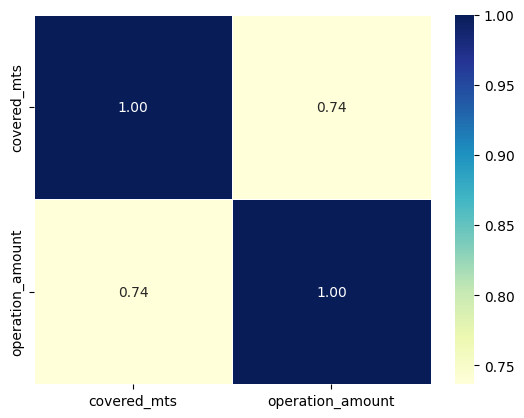

In [ ]:
corr_matrix = df_merge[['covered_mts','operation_amount']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)

In [ ]:
#pairplot_filter = ['expenses_amount','total_mts','covered_mts','rooms','bedrooms','bathrooms','garages','antique','operation_amount']
#df_corr = df[pairplot_filter]
#rooms = np.sort(df_corr.rooms.unique())
#for room_qty in rooms:
#  plt.figure(figsize=(10, 8))
 # df_filt = df_corr[df_corr['rooms'] == room_qty]
 # corr_matrix = df_filt.corr()
 # sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
 # plt.title(f'Matriz de Correlación con {room_qty} rooms con {df_filt.shape[0]} registros')

In [ ]:
#sns.pairplot(df_corr, hue = 'operation_amount',  corner = True, diag_kind='hist')

In [ ]:
df.city.value_counts().reset_index().shape

(57, 2)

<Axes: >

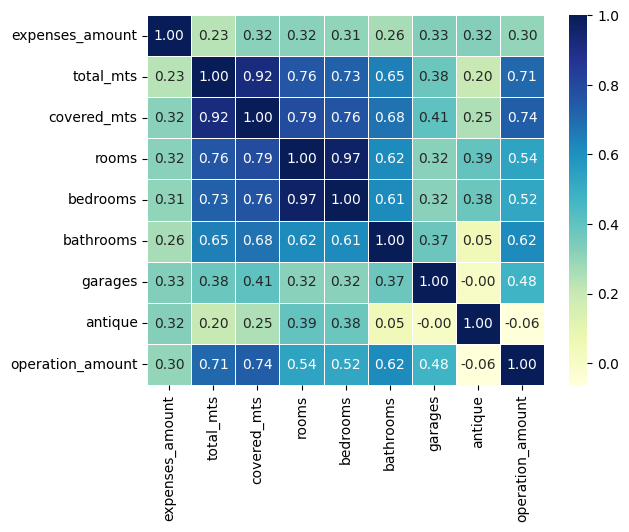

In [ ]:
pairplot_filter = ['expenses_amount','total_mts','covered_mts','rooms','bedrooms','bathrooms','garages','antique','operation_amount']
df_corr = df_merge[pairplot_filter].corr()
sns.heatmap(df_corr, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)

In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10261 entries, 0 to 13648
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            10261 non-null  int64  
 1   operation_amount              10261 non-null  float64
 2   expenses_amount               10261 non-null  float64
 3   total_mts                     10261 non-null  float64
 4   covered_mts                   10261 non-null  float64
 5   rooms                         10261 non-null  int64  
 6   bedrooms                      10261 non-null  int64  
 7   bathrooms                     10261 non-null  int64  
 8   garages                       10261 non-null  int64  
 9   antique                       10261 non-null  float64
 10  orientation                   10261 non-null  object 
 11  real_estate_type              10261 non-null  object 
 12  posting_type                  10261 non-null  object 
 13  state 

In [ ]:
df_merge.reset_index(inplace=True)

# Modelado

## Regresion Lineal
En base a la correlación mostrada anteriormente, probaremos realizar una regresión lineal únicamente con la variable covered_mts

Utilizar este modelo como modelo heurística (Agregando las city)

###Selección de columnas

In [ ]:
# # df_rl = df[['covered_mts','city','operation_amount']]
# df_rl = df[['covered_mts','operation_amount']]
# df_rl.info()

###Generación de X e y

In [ ]:
# # df_rl = pd.get_dummies(df_rl, drop_first=True)
# df_rl.head()

In [ ]:
# # features = list(df_rl.columns) - ['operation_amount']
# X = df_rl[['covered_mts']]
# y = df_rl[['operation_amount']]

###Train-Test Split

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Escalamiento de valores

In [ ]:
# # Crear el escalador
# scaler = StandardScaler()

# # Ajustar el escalador en el conjunto de entrenamiento y transformar
# # X_train = scaler.fit_transform(X_train)

# # # Transformar el conjunto de prueba
# # X_test = scaler.transform(X_test)

# # Crear el escalador para la variable objetivo
# scaler_y = StandardScaler()


###Modelo

In [ ]:
# # Crear el modelo de regresión lineal
# model = LinearRegression()

# # Entrenar el modelo
# model.fit(X_train, y_train)

# # Hacer predicciones
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

###Métricas

In [ ]:
# # Calcular métricas de evaluación
# mae_train = mean_absolute_error(y_train, y_train_pred)
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# r2_train = r2_score(y_train, y_train_pred)

# mae_test = mean_absolute_error(y_test, y_test_pred)
# mse_test = mean_squared_error(y_test, y_test_pred)
# rmse_test = np.sqrt(mse_test)
# r2_test = r2_score(y_test, y_test_pred)

# print("Desempeño en el conjunto de entrenamiento:")
# print(f"MAE: {mae_train}")
# print(f"MSE: {mse_train}")
# print(f"RMSE: {rmse_train}")
# print(f"R²: {r2_train}")

# print("\nDesempeño en el conjunto de prueba:")
# print(f"MAE: {mae_test}")
# print(f"MSE: {mse_test}")
# print(f"RMSE: {rmse_test}")
# print(f"R²: {r2_test}")

###Gráfico

In [ ]:
# # Inversión de la escala para las predicciones y valores reales
# # y_test_inv = scaler_y.inverse_transform(y_test)
# # y_pred_inv = scaler_y.inverse_transform(y_test_pred)
# X_test_scat = X_test.covered_mts.values
# y_test_inv = y_test.operation_amount.values
# y_pred_inv = y_test_pred

# # Crear un DataFrame para facilitar la visualización
# result_df = pd.DataFrame({
#     # 'Covered mts': X_test[:, 0],
#     'Covered mts': X_test_scat,
#     'Real Operation Amount': y_test_inv.flatten(),
#     'Predicted Operation Amount': y_pred_inv.flatten()
# })

# # Gráfica de dispersión de Covered mts vs Operation Amount
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='Covered mts', y='Real Operation Amount', data=result_df, label='Real')
# plt.plot('Covered mts', 'Predicted Operation Amount', color='red', data=result_df, label='Predicted')
# plt.title('Covered mts vs Operation Amount')
# plt.xlabel('Covered mts')
# plt.ylabel('Operation Amount')
# plt.legend()
# plt.show()

## MODELO

In [ ]:
from sklearn.metrics import (mean_absolute_error, r2_score,

                             mean_absolute_percentage_error)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:


df_merge.drop(columns=['publication_antiquity','state','posting_type','real_estate_type','id'], inplace=True)
#df_merge['building_layout'] = df_merge['building_layout'].astype('category')
#df_merge['orientation'] = df_merge['orientation'].astype('category')
df_merge.drop(columns=['orientation'], inplace=True)
df_merge.drop(columns=['latitude','longitude','reserved'], inplace=True)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         10261 non-null  int64  
 1   operation_amount              10261 non-null  float64
 2   expenses_amount               10261 non-null  float64
 3   total_mts                     10261 non-null  float64
 4   covered_mts                   10261 non-null  float64
 5   rooms                         10261 non-null  int64  
 6   bedrooms                      10261 non-null  int64  
 7   bathrooms                     10261 non-null  int64  
 8   garages                       10261 non-null  int64  
 9   antique                       10261 non-null  float64
 10  COMUNA_1                      10261 non-null  int64  
 11  COMUNA_10                     10261 non-null  int64  
 12  COMUNA_11                     10261 non-null  int64  
 13  C

In [ ]:
X = df_merge.drop(columns=['operation_amount','index'])
y = df_merge['operation_amount']


In [ ]:
# Separamos el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Crear una instancia de StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Ajustar el scaler al conjunto de entrenamiento y transformar
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Transformar el conjunto de testeo
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
!pip install xgboost
import xgboost as xgb

In [ ]:
# Inicializamos XGBoost con sus hiperparámetros por defecto
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
xgb_regressor.fit(X_train_scaled, y_train_scaled)

# Calculamos las métricas
y_pred_xgb = xgb_regressor.predict(X_test_scaled)

y_test_inversed = scaler_y.inverse_transform(y_test_scaled)
y_pred_inversed = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))

metrics_xgb = {
    "name": "XGBoost",
    "MAE_training": mean_absolute_error(y_train_scaled, xgb_regressor.predict(X_train_scaled)),
    "MAE": mean_absolute_error(y_test_inversed, y_pred_inversed),
    "MSE" : mean_squared_error(y_test_inversed, y_pred_inversed),
    "RMSE": np.sqrt(mean_squared_error(y_test_inversed, y_pred_inversed)),
    "MAPE": mean_absolute_percentage_error(y_test_inversed, y_pred_inversed),
    "R2": r2_score(y_test_inversed, y_pred_inversed)

}
metrics_xgb



{'name': 'XGBoost',
 'MAE_training': 0.1464749530301856,
 'MAE': 36300.10313413297,
 'MSE': 3357600837.0109267,
 'RMSE': 57944.80854236147,
 'MAPE': 0.17491216455283679,
 'R2': 0.8232581315113972}

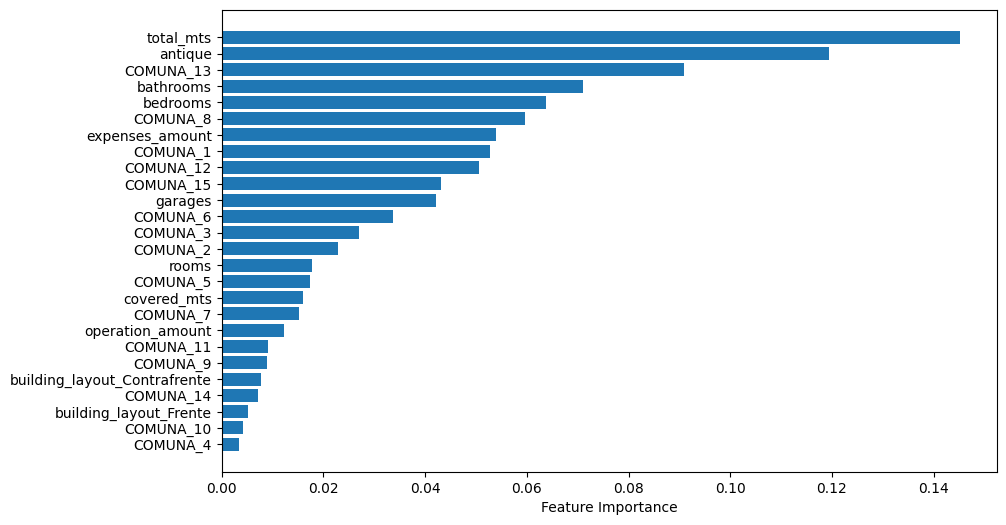

In [ ]:
# Obtenemos la importancia de características
feature_importances = xgb_regressor.feature_importances_
feature_names = df_merge.columns[:-1]  # Excluir la columna objetivo

# Ordenamos los índices
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

bathroms? algunos barrios mas importantes que otros?



In [ ]:
df_merge['bathrooms'].value_counts()


bathrooms
1    6563
2    3017
3     681
Name: count, dtype: int64

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   expenses_amount               10261 non-null  float64
 1   total_mts                     10261 non-null  float64
 2   covered_mts                   10261 non-null  float64
 3   rooms                         10261 non-null  int64  
 4   bedrooms                      10261 non-null  int64  
 5   bathrooms                     10261 non-null  int64  
 6   garages                       10261 non-null  int64  
 7   antique                       10261 non-null  float64
 8   COMUNA_1                      10261 non-null  int64  
 9   COMUNA_10                     10261 non-null  int64  
 10  COMUNA_11                     10261 non-null  int64  
 11  COMUNA_12                     10261 non-null  int64  
 12  COMUNA_13                     10261 non-null  int64  
 13  C

In [ ]:
#regresion
# Entrenamos la regresión lineal
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Calculamos las métricas
y_pred_linear = linear_regressor.predict(X_test)

metrics_linear = {
    "name": "Regresión lineal",
    "MAE_training": mean_absolute_error(y_train, linear_regressor.predict(X_train)),
    "MAE": mean_absolute_error(y_test, y_pred_linear),
    "MSE" : mean_squared_error(y_test, y_pred_linear),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_linear)),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_linear),
    "R2": r2_score(y_test, y_pred_linear)
}

metrics_linear


{'name': 'Regresión lineal',
 'MAE_training': 48598.88487218186,
 'MAE': 46691.24496833243,
 'MSE': 4822498196.987773,
 'RMSE': 69444.20924013588,
 'MAPE': 0.26188434999934385,
 'R2': 0.7461469115913959}

## GRAFICO Y-TEST vs Y-PRED

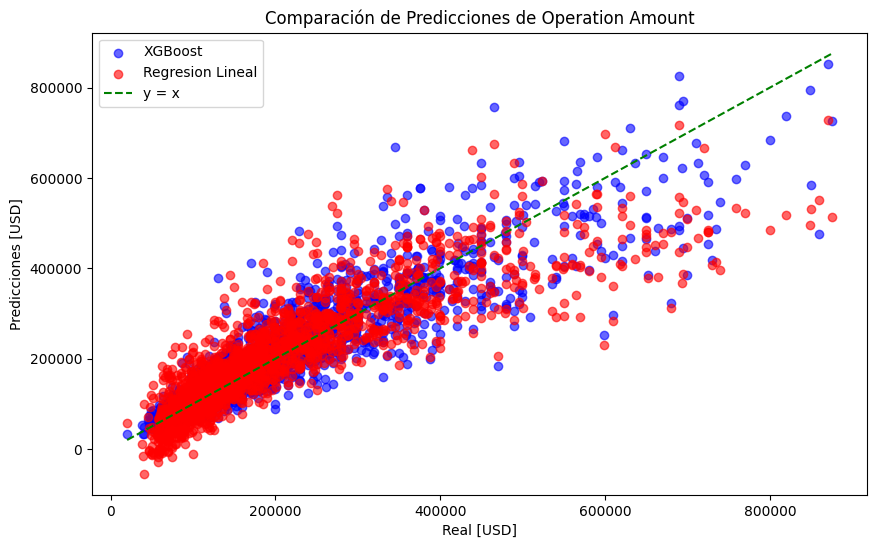

In [ ]:
plt.figure(figsize=(10, 6))

# Graficar las predicciones del modelo 1 vs y_test
plt.scatter(y_test_inversed, y_pred_inversed, color='blue', label='XGBoost', alpha=0.6)
# Graficar las predicciones del modelo 2 vs y_test
plt.scatter(y_test_inversed, y_pred_linear, color='red', label='Regresion Lineal', alpha=0.6)

# Añadir una línea de referencia (y = x)
plt.plot([min(y_test_inversed), max(y_test_inversed)], [min(y_test_inversed), max(y_test_inversed)], color='green', linestyle='--', label='y = x')

# Añadir etiquetas y título
plt.xlabel('Real [USD]')
plt.ylabel('Predicciones [USD]')
plt.title('Comparación de Predicciones de Operation Amount')

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

- Ver escalamiento de datoss en modelos
PAra valores menores a 400 usd, los dos modeos perfroman parecido al aumentar el operation_amount, el modelo lineal solo se va quedando muy por abajo, y el xgboost intenta seguir mejor al valor real (or eso mejora la performance)